# <h1 style="text-align: center;"> Tarea 01 <br> (*Sara Luz Valenzuela Camacho*) </h1>

En las primeras clases del curso estaremos trabajando en desarrollar buenas prácticas para construir productos de datos. La parte conceptual como la parte de programación son igualmente importantes. Para poder bajar las ideas a la práctica necesitamos una muestra de código.

# Contexto: </br>
* Supon que estamos trabajando en una start up de bienes raices y necesitamos construir un producto de datos que ayude a soportar una aplicación para que nuestros clientes (compradores/vendedores) puedan consultar una estimación del valor de una propiedad de bienes raíces.

* Aún el CEO no tiene claro como debe de diseñarse esta aplicación. Nostros como data scientists debemos proponer una Prueba de Concepto, que permita experimentar rápido, dar un look an feel de la experiencia y nos permita fallar rápido para probar una siguiente iteración.



# Objetivo:
* Prototipa un modelo en Python que permita estimar el precio de una casa dadas algunas características que el usuario deberá proporcionar a través de un front al momento de la inferencia.

# Datos:
* En vista de que el CEO no tiene mucha claridad, podemos construir un dataset con dato sintéticos o tomar alguno otro como referencia, para poder desarrollar nuestra idea.

* Para lo cual usaremos el conjunto de precios de compra-venta de casas de la ciudad Ames, Iowa en Estados Unidos.



# Entregable
* Un notebook o notebooks que puedas presentar, desarrollando todos los pasos que seguiste para construir tu modelo.

* Recuerda incluir la ingeniería de características, la selección de variabales, el entrenamiento del modelo, la evaluación del ajuste y un ejemplo de como se ejecutaran las inferencias.

# Out of Scope:
* Desarrollar una herramienta, API, etc.

# Contenido
1. [Carga de Datos](#load_data)
2. [Problema](#problem)
3. [Data Overiew](#overview)
4. [Limpieza de datos](#cleaning)
5. [Variable Objetivo](#Vobjective)
6. [Variables Descriptivas](#Vdescriptive)
7. [Correlaciones](#correlation)
8. [Ingeniería de Variables](#ing)
9. [Baseline](#baseline)
10. [Predicción](#conclusion)
11. [Referencias](#references)

<a id="load_data"></a>
## 1. Carga de datos

### Importamos las Bibliotecas

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore")

### Leemos los datos

In [11]:
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')

<a id="problem"></a>
## 2. Problema

Debemos elegir algunas características de las casas, para que con base en éstas el usuario pueda estimar el precio. 

Como tenemos muy pocos datos de cómo se va a usar el producto vamos a hacer algunas suposiciones:

* La aplicación va a ser usada por personas NO especializadas en la valuación de inmuebles, por lo que habrá muchas variables que no conocerá, y por tanto no se podrán usar como input, o que se tendrán que ajustar a un menor nivel de especialización.

* Suponemos que va a ser usada por personas que quieren comprar o vender una casa o departamento y quieren darse una idea de cuanto pueden recibir.

* El producto se va a usar para el mercado de la Ciudad de México, esto implica que habrá variables que no se considerarán por el clima y cultura. Los datos que se están usando obviamente van a dar predicciones erroneas para la Ciudad de México, dado que en inmuebles la ubicación es un gran factor (debido a la demanda). Así que este sólo sería un ejercicio para jugar un poco con cómo debe ser o por dónde va la idea.

* La predicción se considerará exitosa si se encuentra en +- $500,000.00 M.N. Esto porque se está "mexicanizando" el problema con datos de otro lugar.

<a id="overview"></a>
## 3. Data Overview

### Número de registro y número de variables

In [12]:
train_data.shape

nrecords = train_data.shape[0]

Son 81 variables, y 1460 datos.

Revisamos los nombres de las variables

In [13]:
print(train_data.columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Analicemos que variables nos pueden servir (en **negritas**), y a descartar algunas simplemente por su naturalesa:

**Variable Objetivo:**
* **SalePrice** - el precio de la propiedad en dólares. **Hay que transformarlo a pesos.**

**Variables Descriptivas:**

* Id: Identificador, no nos sirve para el modelo, se debe eliminar.

* MSSubClass: La clase de edificio. Aunque parece numérica es en realidad categórica. 

* MSZoning: La clasificación general de la zona, puede ser: agricultural, comercial, industrial o de diferentes tipos de habitacional. 

* **LotFrontage**: Pies lineales de fachada o frente. **Convertir a metros**

* **LotArea**: pies cuadrados que mide el terreno **convertir a metros**

* **Street**: Terracería o pavimento.

* Alley: El callejón que se ve en las películas donde tiran la basura y que no está hecho para el tránsito de vehículos.

* LotShape: 4 niveles de regularidad (o irregularidad). Esta variable se puede transformar a ordinal.

* LandContour: Pendiente del terreno aledaño, puede estar: nivelado, en una colina, en pendiente o en una barranca.

* **Utilities**: puede ser: todos los servicios (Electricidad, Gas, Agua y Drenaje), solo electricidad, gas y agua, solo electricidad y gas, o solo electricidad. **Esta variable también se puede hacer ordinal.**

* LotConfig: Confguración o posición de la casa dentro del lote.

* LandSlope: Pendiente del terreno, tres niveles. Puede convertirse en variable ordinal.

* **Neighborhood**: Ubicación, como si fuera colonia.

* **Condition1**: Proximidad a vías principales y al ferrocarril.

* **Condition2**: Misma que la anterior por si tiene una característica extra

* **BldgType**: Tipo de prototipo, duplex, casa, etc.

* **HouseStyle**: Numero de pisos terminados.

* **OverallQual**: calidad de materiales y acabados, variable ordinal con 10 niveles. **Bajar a 3 niveles**

* **OverallCond**: Condición general, variable ordinal con 10 niveles. **Bajar a 3 niveles**

* **YearBuilt**: Año en que se construyó.

* YearRemodAdd: Año de la última remodelación, si no hay remodelaciones, es el mismo que la construcción.

* RoofStyle: Tipo del Techo

* RoofMatl: Material del Techo

* Exterior1st: Materiales del acabado exterior

* Exterior2nd: Materiales del acabado exterior, si son más de uno.

* MasVnrType: Tipo de mampostería

* MasVnrArea: Área con acabado de mampostería

* ExterQual: Calidad de los materiales en el exterior, 5 niveles. Esta variable puede hacerse ordinal.

* ExterCond: Condición actual de los materiales del exterior. 5 niveles. Esta variable puede hacerse ordinal.

* Foundation: Tipo de cimentación

* BsmtQual: Altura del sótano, 5 rangos y una opción de sin sótano.

* **BsmtCond**: Condición general del sótano, 5 rniveles y una opción de sin sótano. **convertir a tiene o no sótano**

* BsmtExposure: WQué tanto se ve del jardín desde el sótano, 4 niveles y una opción de sin sótano.

* BsmtFinType1: Nivel de acabado del sótano, 6 niveles y una opción de sin sótano.

* BsmtFinSF1: pies cuadrádos con ese nivel de acabado.

* BsmtFinType2: Si existen acabados en otra calidad.

* BsmtFinSF2: pies cuadrádos con ese nivel de acabado (tipo 2).

* BsmtUnfSF: pies cuadrados del sótano sin acabado.

* **TotalBsmtSF**: pies cuadrados totales de sótano, **convertir a metros**

* Heating: Tipo de calefacción, 6 opciones.

* HeatingQC: Calidad de la calefacción. 5 niveles, puede convertirse en variable ordinal.

* CentralAir: Aire acondicionado central, variable binaria.

* Electrical: Tipo de sistema eléctrico.

* 1stFlrSF: pies cuadrádos del primer piso.

* 2ndFlrSF: pies cuadrádos del segundo piso.

* LowQualFinSF: pies cuadrados construidos de baja calidad.

* **GrLivArea**: pies cuadrados construidos arriba del suelo. **convertir a metros**

**Sumar todos los baños en una sola variable**

* **BsmtFullBath**: Baños completos en el sótano.

* **BsmtHalfBath**: medios baños en el sótano.

* **FullBath**: Baños completos arriba del suelo.

* **HalfBath**: Medios baños arriba del suelo.

* **Bedroom**: Numero de cuartos arriba del nivel del sótano.

* Kitchen: Número de cocinas arriba del nivel del suelo.

* **KitchenQual**: Calidad de la cocina, 5 niveles, puede hacerse ordinal.

* TotRmsAbvGrd: Total de cuartos arriba del nivel del suelo.

* Functional: Rating de Funcionalidad, asume funcionalidad típica a menos que haya deducciones.

* Fireplaces: Número de chimeneas.

* FireplaceQu: calidad de la chimenea, 5 niveles y una opción si no existe.

* GarageType: Ubicación del garage

* GarageYrBlt: año en que se construyó el garage.

* GarageFinish: Acabado interior del garage.

* **GarageCars**: número de autos que caben en el garage.

* GarageArea: Tamaño del garage en pies cuadrados.

* GarageQual: Calidad del garage, 5 niveles y una opción si no hay.

* GarageCond: Condición del garage, 5 niveles y una opción si no hay.

* **PavedDrive**: Entrada de autos pavimentada. Tres opciones.

**Vamos a sumar todas las variables semejantes a porche o terraza, y a considerarla terraza**

* **WoodDeckSF**: área de terraza con piso de madera en pies cuadrados. **convertir a metros**

* **OpenPorchSF**: Terraza techada en pies cuadrados. **convertir a metros**

* **EnclosedPorch**: terraza cerrada en pies cuadrados. **convertir a metros**

* **3SsnPorch**: Porche de tres estaciones en pies cuadrados. **convertir a metros**

* **ScreenPorch**:metros cuadrados de un screen proch. **convertir a metros**

* PoolArea: Piscina área en pies cuadrados

* PoolQC: Calidad de piscina, 4 niveles y una opción si no hay.

* Fence: Calidad de cerca, 5 niveles desde no hay hasta máxima privacidad.

* **MiscFeature**: Miselaneo o extra

* MiscVal: Valor monetario de lo misceláneo

* MoSold: Mes en el que se vendió

* **YrSold**: Año en el que se vendió

* SaleType: Tipo de venta

* **SaleCondition**: Condiciones de la venta


<a id="cleaning"></a>
## 4. Limpieza de Datos

### Primero nos quedamos sólo con las columnas que nos interesan

In [14]:
train_data_cln = train_data[['LotFrontage', 'LotArea', 'Street',
        'Utilities', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'BsmtCond',  'TotalBsmtSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr',  'KitchenQual',
       'GarageCars', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscFeature', 
       'SaleCondition', 'SalePrice']]

### Ahora convertimos unidades (dolares a pesos, $ft^2$ a $m^2$)

In [15]:
TdeC = 17.16 # 30-ene-2024
ft2 = 0.092903 # metros cuadrados
ft = 0.3048 # metros

train_data_cln['LotFrontage'] = train_data['LotFrontage']*ft
train_data_cln['LotArea'] = train_data['LotArea']*ft2
train_data_cln['TotalBsmtSF'] = train_data['TotalBsmtSF']*ft2
train_data_cln['GrLivArea'] = train_data['GrLivArea']*ft2
train_data_cln['WoodDeckSF'] = train_data['WoodDeckSF']*ft2
train_data_cln['OpenPorchSF'] = train_data['OpenPorchSF']*ft2
train_data_cln['EnclosedPorch'] = train_data['EnclosedPorch']*ft2
train_data_cln['3SsnPorch'] = train_data['3SsnPorch']*ft2
train_data_cln['ScreenPorch'] = train_data['ScreenPorch']*ft2
train_data_cln['SalePrice'] = round(train_data['SalePrice']*TdeC/3,0) # las cantidades quedan como miles de pesos


In [36]:

print(train_data_cln['SalePrice'].describe())
print(min(train_data_cln['SalePrice']))
print(max(train_data_cln['SalePrice']))

count    1.460000e+03
mean     1.034869e+06
std      4.544111e+05
min      1.996280e+05
25%      7.434570e+05
50%      9.323600e+05
75%      1.224080e+06
max      4.318600e+06
Name: SalePrice, dtype: float64
199628.0
4318600.0


### Revisamos cuantos datos tenemos:

In [16]:
train_data_cln.isnull().sum()

LotFrontage       259
LotArea             0
Street              0
Utilities           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
BsmtCond           37
TotalBsmtSF         0
GrLivArea           0
BsmtFullBath        0
BsmtHalfBath        0
FullBath            0
HalfBath            0
BedroomAbvGr        0
KitchenQual         0
GarageCars          0
PavedDrive          0
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
MiscFeature      1406
SaleCondition       0
SalePrice           0
dtype: int64

In [17]:
vacios = []
field = []
for col in train_data_cln.columns.tolist(): 
    field.append(col)
    vacios.append(train_data[col].isnull().sum())
vacios = np.array(vacios)/nrecords*100

In [18]:
tot=(100-vacios)


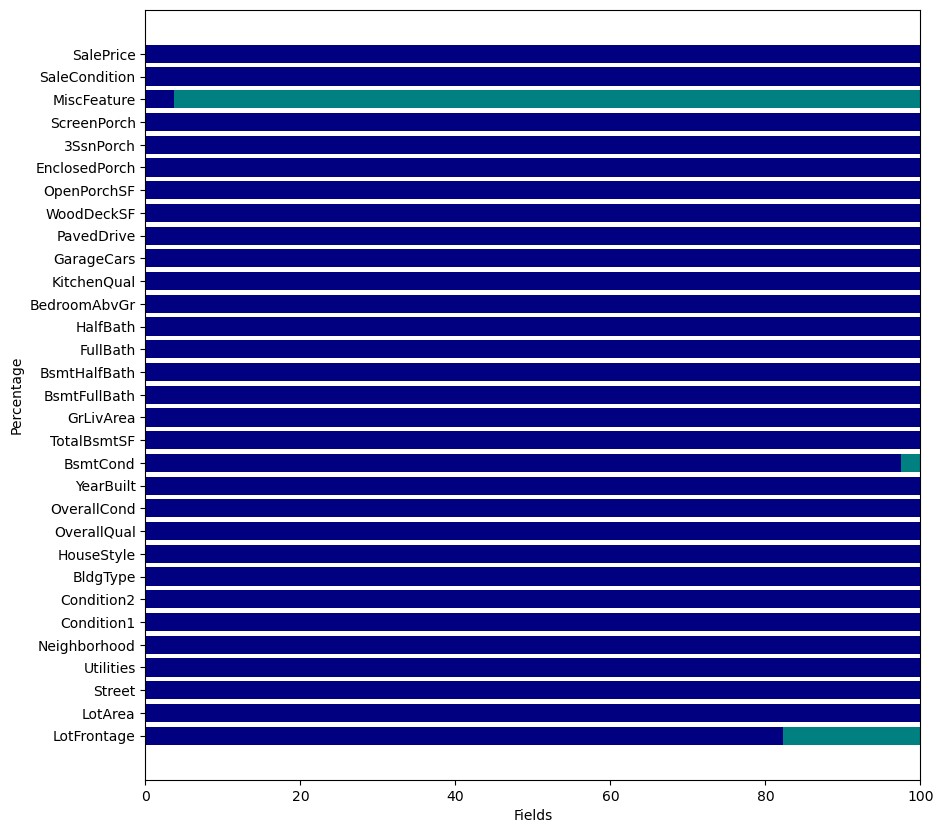

In [19]:
plt.figure(figsize = (10,10))
plt.barh(field, tot, color='navy')
plt.barh(field, vacios, left=tot, color='teal')
plt.rcParams['ytick.labelsize']= 12
plt.xlabel("Fields")
plt.ylabel("Percentage")
plt.show()

### Tenemos cuatro opciones para lidiar con los datos faltantes:
1. Quitar esos datos (renglones o la variable completa)
2. Usar media, mediana o moda (según sea datos numérico o categórico), para rellenar
3. Usar correlaciones para rellenar
4. Recolectar los datos que faltan si es posible
### Más adelante se deberá usar la opción 4 para obtener datos del mercado en el que se va a hacer la predicción. Por ahora, usaremos el promedio para la variable de 'LotFrontage', y para las variables 'BsmtCond' y 'MiscFeature', se colocara la opción de 'NA' es decir sin sótano o sin extras, respectivamente.

In [20]:
train_data_cln['BsmtCond'] = train_data_cln['BsmtCond'].fillna('NA')
train_data_cln['MiscFeature'] = train_data_cln['MiscFeature'].fillna('NA')

for c in train_data_cln.columns:
    if(train_data_cln[c].dtype!='object'):
        train_data_cln[c].fillna(train_data_cln[c].mean(), inplace = True)

#train_data_cln.isnull().sum()

(Falta box plot, quitar outliers)

<a id="Vobjective"></a>
## 5. Variable Objetivo

Distribución de los precios de las casas:

count    1.460000e+03
mean     1.034869e+06
std      4.544111e+05
min      1.996280e+05
25%      7.434570e+05
50%      9.323600e+05
75%      1.224080e+06
max      4.318600e+06
Name: SalePrice, dtype: float64


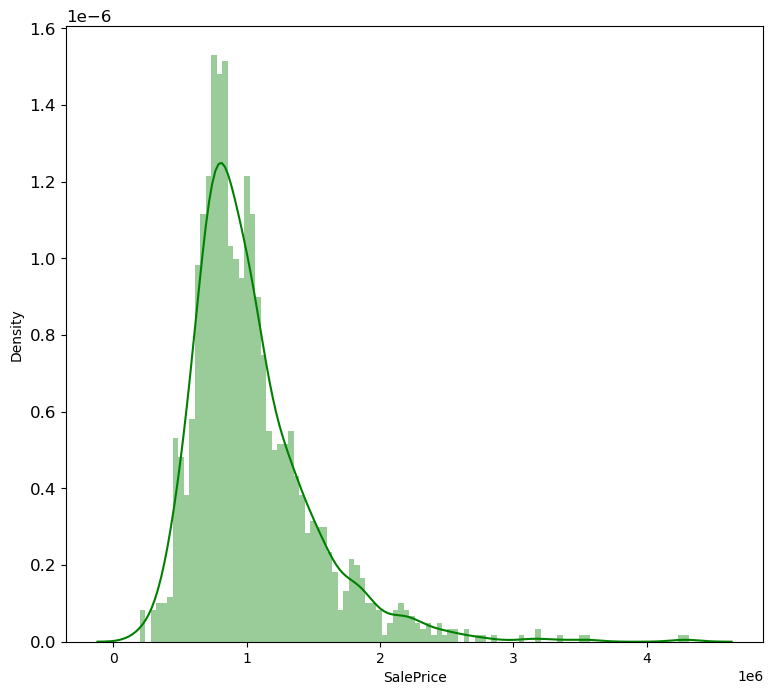

In [21]:
print(train_data_cln['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(train_data_cln['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});


Podemos ver que los precios de las casas se encuentran por debajo de los de la CDMX (las casas en promedio son más caras de 1M, y pueden llegar a costar más de 5M).

<a id="Vdescriptive"></a>
## 6. Variables descriptivas

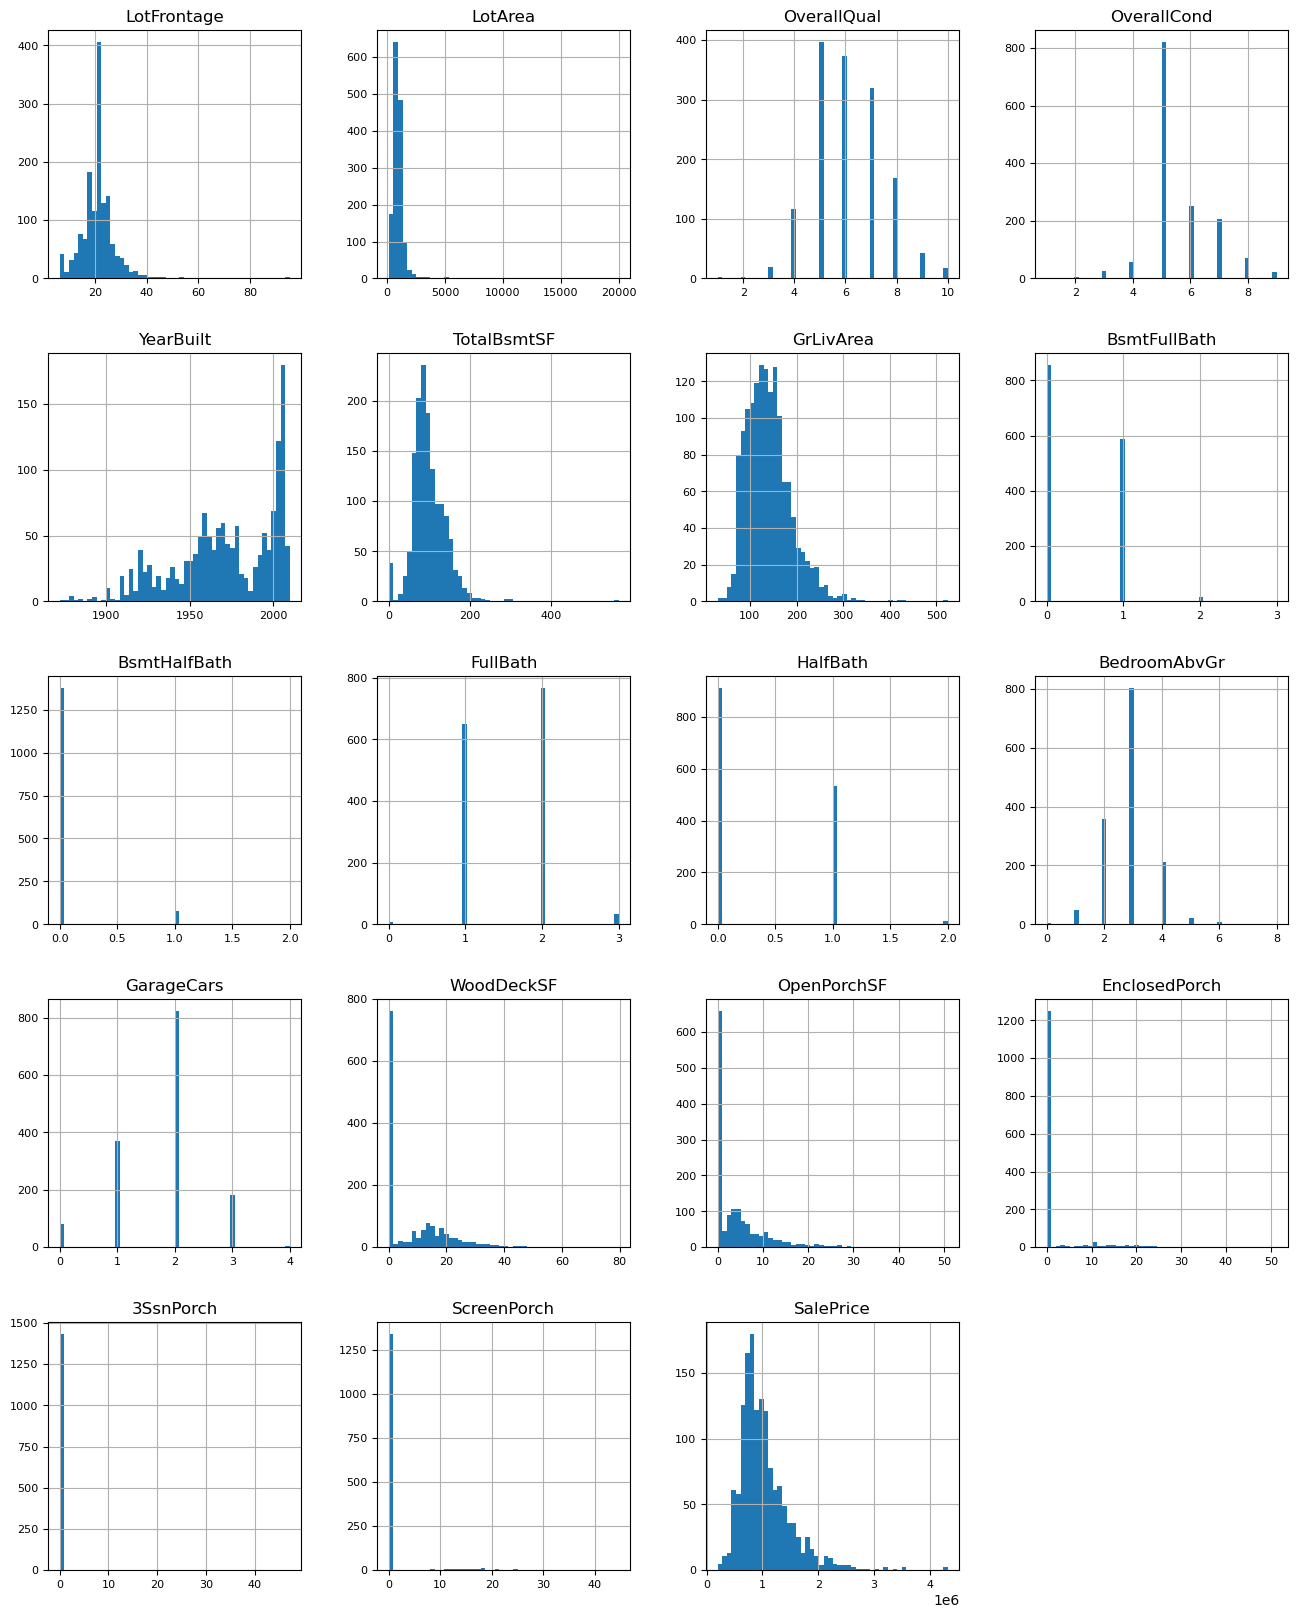

In [22]:
df_num = train_data_cln.select_dtypes(include = ['float64', 'int64'])
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

<a id="correlation"></a>
## 7. Correlaciones

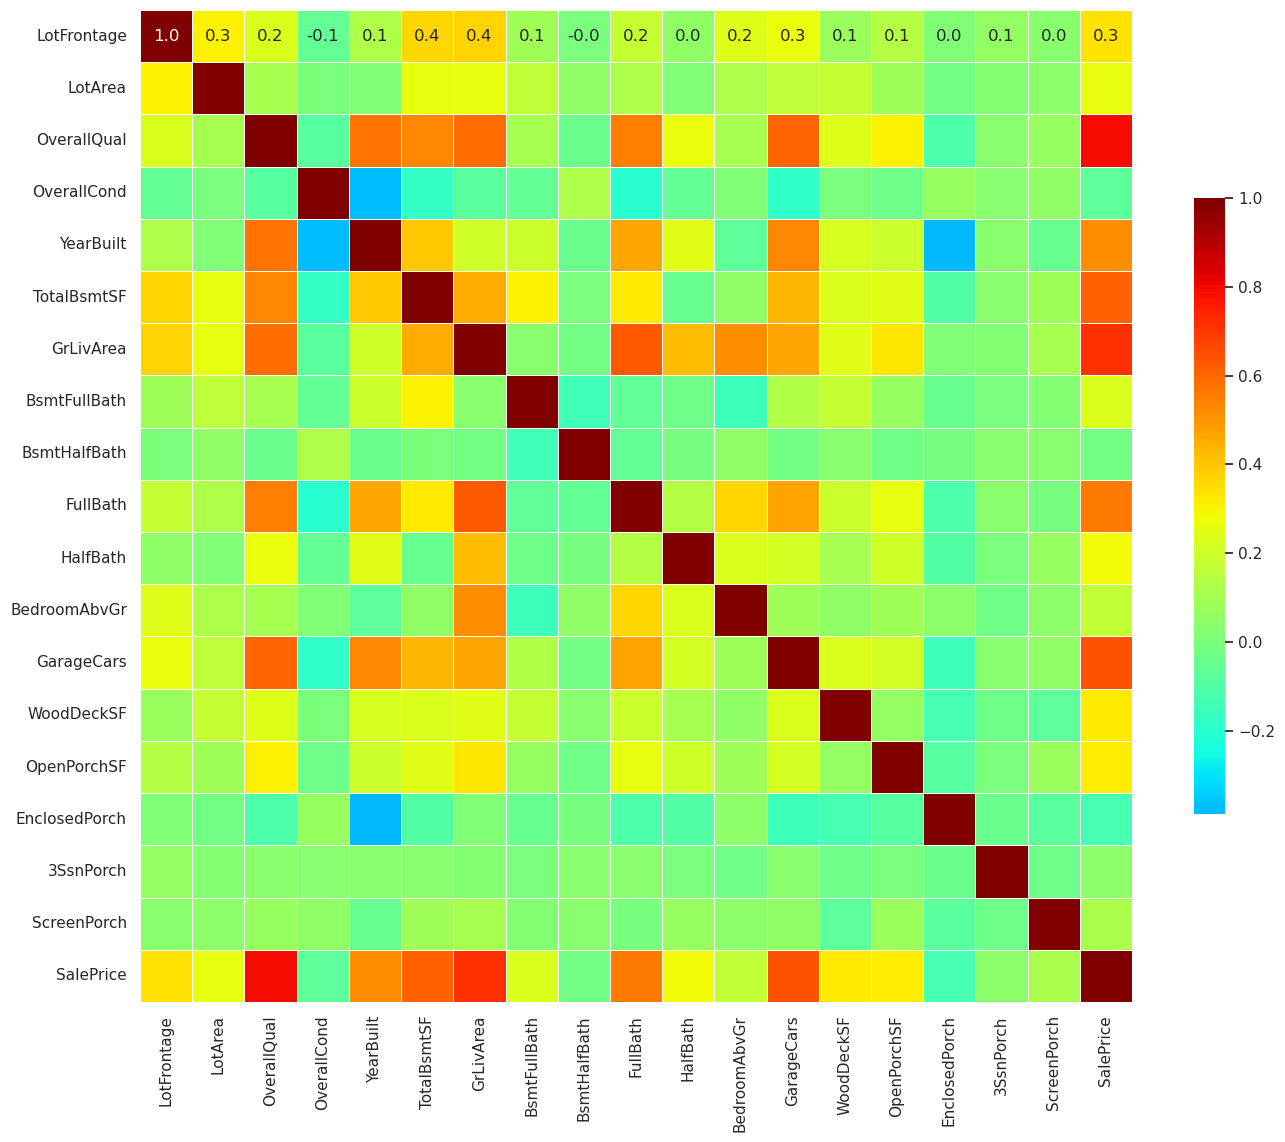

In [23]:
# Let's explore correlations between pairs of variables
plt.figure(figsize = (16,16))
corrmat = df_num.corr()
sns.set(font_scale=1.0)
sns.heatmap(corrmat, center=0, cmap='jet', square=True, cbar_kws={"shrink": .5}, linewidths=.5, annot=True, fmt=".1f")
plt.show()

#print(corrmat[])

<a id="ing"></a>
## 5. Ingeniería de Variables

In [24]:
train_data_ing = train_data_cln[['LotFrontage', 'LotArea', 'Street', 'Utilities', 
       'YearBuilt', 'BedroomAbvGr',
       'KitchenQual', 'GarageCars', 'PavedDrive', 
       'SalePrice', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'MiscFeature', 'SaleCondition']]

### Primero vamos a bajar el número de opciones es las variables: 

* 'OverallQual', reducir a 3 opciones 
* 'OverallCond', reducir a 3 opciones
* 'BsmtCond', dos opciones, con o sin sótano

In [25]:
dic_qual ={1 : 3, 
        2 : 3,
        3 : 3,
        4 : 3,
        5 : 2,
        6 : 2,
        7 : 2,
        8 : 1,
        9 : 1,
        10 : 1}
train_data_ing['OverallQual'] = train_data_cln['OverallQual'].map(dic_qual)
train_data_ing['OverallCond'] = train_data_cln['OverallCond'].map(dic_qual)


In [26]:
train_data_ing['sotano'] =  np.where(train_data_cln['BsmtCond']=='NA', 0, 1)

### Luego vamos a sumar:

* banos_completos = 'BsmtFullBath' + 'FullBath' 
* medios_banos = 'BsmtHalfBath' + 'HalfBath'
* m2construidos = 'TotalBsmtSF' + 'GrLivArea'
* terraza = 'WoodDeckSF' + 'OpenPorchSF' + 'EnclosedPorch' + '3SsnPorch' + 'ScreenPorch'

In [27]:
train_data_ing['banos_completos'] = train_data_cln['BsmtFullBath'] + train_data_cln['FullBath']
train_data_ing['banos_medios'] = train_data_cln['BsmtHalfBath'] + train_data_cln['HalfBath']
train_data_ing['m2construidos'] = train_data_cln['TotalBsmtSF'] + train_data_cln['GrLivArea']
train_data_ing['m2terraza'] = train_data_cln['WoodDeckSF'] + train_data_cln['OpenPorchSF'] + train_data_cln['EnclosedPorch'] + train_data_cln['3SsnPorch'] + train_data_cln['ScreenPorch']

Convertimos a ordinal algunas categorias:

In [28]:
dic_kitchen ={'Ex' : 5, 'Gd' : 4, 'TA': 3, 'Fa': 2, 'Po' : 1}
train_data_ing['KitchenQual'] = train_data_cln['KitchenQual'].map(dic_kitchen)

dic_util ={'AllPub' : 4, 'NoSewr' : 3, 'NoSeWa': 2, 'ELO': 1}
train_data_ing['Utilities'] = train_data_cln['Utilities'].map(dic_util)

dic_street ={'Grvl' : 0, 'Pave' : 1}
train_data_ing['Street'] = train_data_cln['Street'].map(dic_street)

dic_drive ={'Y' : 1, 'P' : 2, 'N': 3}
train_data_ing['PavedDrive'] = train_data_cln['PavedDrive'].map(dic_drive)


Y las demás a onehot encoding:

In [29]:

print(train_data_ing['Neighborhood'].unique()) 
print(train_data_ing['Condition1'].unique()) 
print(train_data_ing['Condition2'].unique()) 
print(train_data_ing['BldgType'].unique()) 
print(train_data_ing['HouseStyle'].unique()) 
print(train_data_ing['MiscFeature'].unique()) 
print(train_data_ing['SaleCondition'].unique()) 

['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
['NA' 'Shed' 'Gar2' 'Othr' 'TenC']
['Normal' 'Abnorml' 'Partial' 'AdjLand' 'Alloca' 'Family']


In [30]:
train_data_ing = pd.get_dummies(train_data_ing, columns = ['Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'MiscFeature', 'SaleCondition']) 

train_data_ing['Condition_Norm'] = train_data_ing['Condition1_Norm'] + train_data_ing['Condition2_Norm']
train_data_ing['Condition_Feedr'] = train_data_ing['Condition1_Feedr'] + train_data_ing['Condition2_Feedr']
train_data_ing['Condition_Artery'] = train_data_ing['Condition1_Artery'] + train_data_ing['Condition2_Artery']
train_data_ing['Condition_RRAn'] = train_data_ing['Condition1_RRAn'] + train_data_ing['Condition2_RRAn']
train_data_ing['Condition_PosN'] = train_data_ing['Condition1_PosN'] + train_data_ing['Condition2_PosN']
train_data_ing['Condition_RRAe'] = train_data_ing['Condition1_RRAe'] + train_data_ing['Condition2_RRAe']
train_data_ing['Condition_PosA'] = train_data_ing['Condition1_PosA'] + train_data_ing['Condition2_PosA']
train_data_ing['Condition_RRNn'] = train_data_ing['Condition1_RRNn'] + train_data_ing['Condition2_RRNn']

train_data_ing = train_data_ing.drop(['Condition1_Norm', 'Condition2_Norm', 'Condition1_Feedr', 'Condition2_Feedr', 'Condition1_Artery', 'Condition2_Artery', 'Condition1_RRAn', 'Condition2_RRAn', 'Condition1_PosN', 'Condition2_PosN', 'Condition1_RRAe', 'Condition2_RRAe', 'Condition1_PosA', 'Condition2_PosA', 'Condition1_RRNn', 'Condition2_RRNn'], axis=1)
train_data_ing.columns

Index(['LotFrontage', 'LotArea', 'Street', 'Utilities', 'YearBuilt',
       'BedroomAbvGr', 'KitchenQual', 'GarageCars', 'PavedDrive', 'SalePrice',
       'OverallQual', 'OverallCond', 'sotano', 'banos_completos',
       'banos_medios', 'm2construidos', 'm2terraza', 'Neighborhood_Blmngtn',
       'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide',
       'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor',
       'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR',
       'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes',
       'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU',
       'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker',
       'Condition1_RRNe', 'BldgType_1Fam', 'BldgType_2fmCon',
       'BldgType_Duplex'

In [34]:
max(train_data_ing['SalePrice'])

4318600.0

In [32]:
#train_data_ing.columns
df_num = train_data_ing.select_dtypes(include = ['float64', 'int64'])
df_num = df_num[['SalePrice', 'm2construidos', 'KitchenQual', 'GarageCars', 'banos_completos', 'YearBuilt', 'm2terraza', 'LotFrontage', 'LotArea', 'banos_medios',
                 'BedroomAbvGr', 'sotano', 'Utilities', 'Street',  'OverallCond', 'PavedDrive', 'OverallQual']]

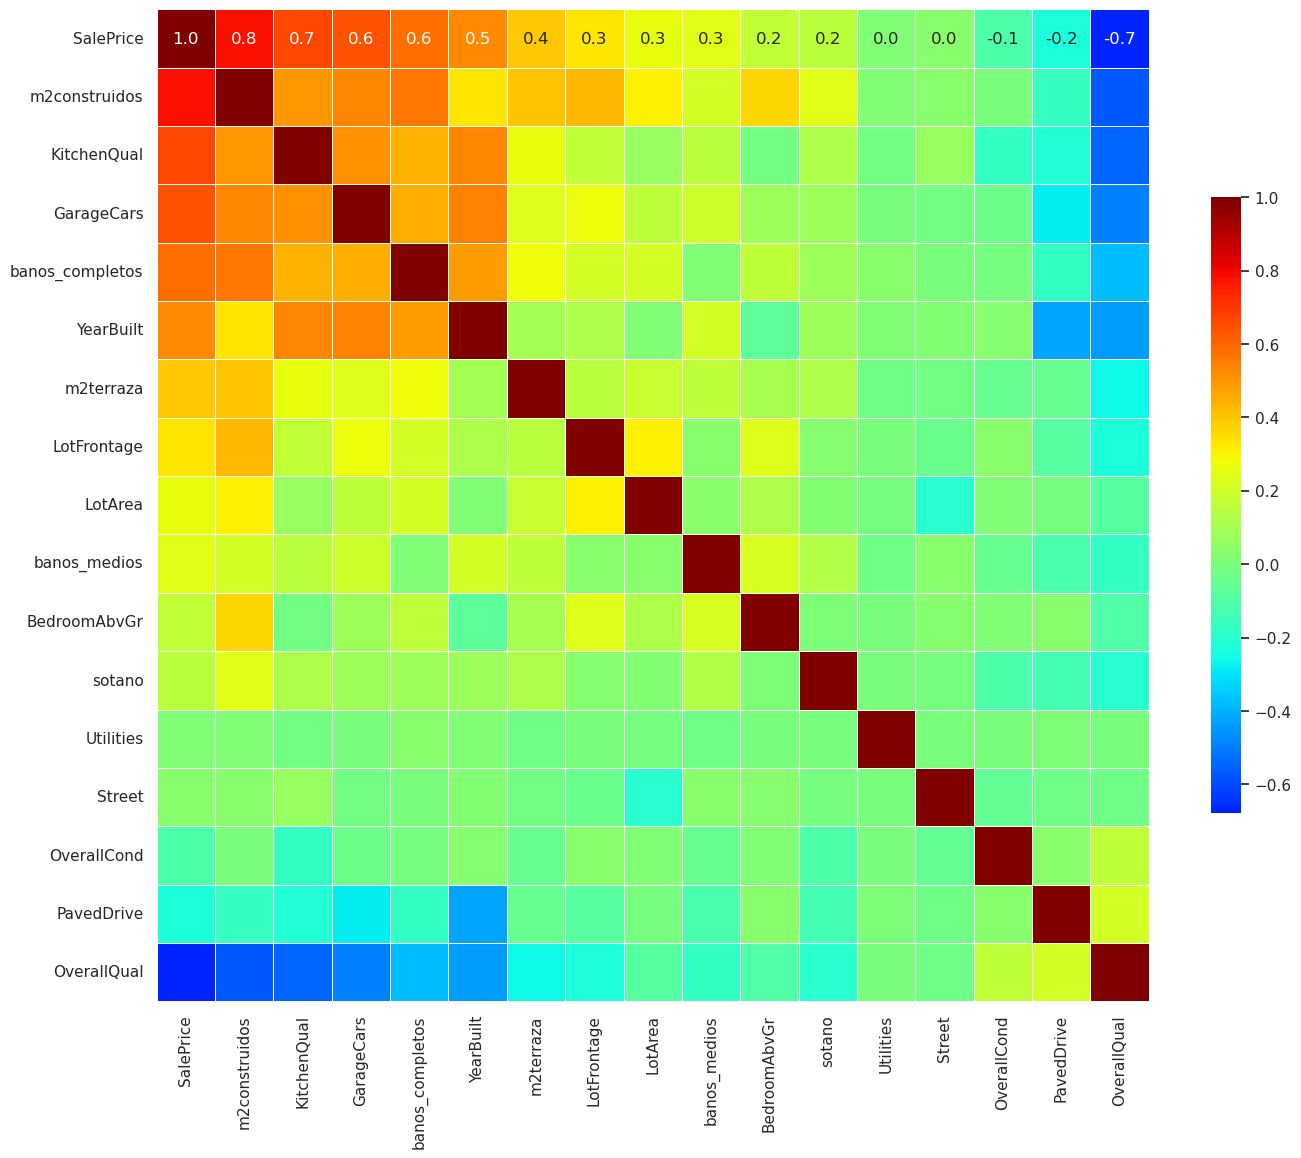

In [33]:
# Let's explore correlations between pairs of variables
plt.figure(figsize = (16,16))
corrmat = df_num.corr()
sns.set(font_scale=1.0)
sns.heatmap(corrmat, center=0, cmap='jet', square=True, cbar_kws={"shrink": .5}, linewidths=.5, annot=True, fmt=".1f")
plt.show()

#print(corrmat[])

<a id="baseline"></a>
## 8. Baseline 

In [ ]:
from sklearn.model_selection import train_test_split


X = train_data_ing
y = train_data_ing['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
def get_best_score(grid):
    
    best_score = np.sqrt(-grid.best_score_)
    print(best_score)    
    print(grid.best_params_)
    print(grid.best_estimator_)
    
    return best_score

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
score_calc = 'neg_mean_squared_error'

param_grid = {'min_samples_split' : [3,4,6,10], 'n_estimators' : [70,100], 'random_state': [5] }
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, refit=True, verbose=1, scoring = score_calc)
grid_rf.fit(X_train, y_train)

sc_rf = get_best_score(grid_rf)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


21696.519453262026
{'min_samples_split': 3, 'n_estimators': 70, 'random_state': 5}
RandomForestRegressor(min_samples_split=3, n_estimators=70, random_state=5)


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

param_grid = {'n_neighbors' : [3,4,5,6,7,10,15] ,    
              'weights' : ['uniform','distance'] ,
              'algorithm' : ['ball_tree', 'kd_tree', 'brute']}

grid_knn = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, refit=True, verbose=1, scoring = score_calc)
grid_knn.fit(X_train, y_train)

sc_knn = get_best_score(grid_knn)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
13610.885458039476
{'algorithm': 'brute', 'n_neighbors': 3, 'weights': 'distance'}
KNeighborsRegressor(algorithm='brute', n_neighbors=3, weights='distance')


In [ ]:
print(sc_rf, sc_knn)

21696.519453262026 13610.885458039476


<a id="pred"></a>
## 9. Predicción

In [ ]:
#como no tengo los precios verdaderos de los datos de test, necesito dividir el set de entrenamiento en dos, para poder probar el modelo

error_arriba = max(round(grid_knn.predict(X_test) - y_test,0))

error_abajo =  min(round(grid_knn.predict(X_test) - y_test,0))

print(error_arriba, error_abajo)

28338.0 -927367.0


### Ejemplo de predicción

In [ ]:
X_test.head(1)['SalePrice'] = 0

In [ ]:
print(y_test.head(1))
grid_rf.predict(X_test.head(1))

892    883740.0
Name: SalePrice, dtype: float64


array([881314.99238095])

El modelo se puede usar para personas que quieren comprar una casa, ya que el error más grande se encuentra dentro de nuestra cota de +$500,000.00 pesos, sin embargo si se usa para saber en cuanto vender una casa, puede sobre estimar por hasta más del 1 millón (máximo).

Dicho esto, el  Root-Mean-Squared-Error (RMSE)  con vecinos más cercanos esta dentro del propuesto +- $500,000.00 pesos.

Como dijimos, estos datos no se pueden usar para la CDMX, pero es una buena primera aproximación para que el cliente se haga una idea de qué busca.

<a id="references"></a>
## 10. Referencias

* Anna Montoya, DataCanary. (2016). House Prices - Advanced Regression Techniques. Kaggle. https://kaggle.com/competitions/house-prices-advanced-regression-techniques
* https://www.kaggle.com/code/gusthema/house-prices-prediction-using-tfdf/notebook
* https://www.kaggle.com/code/dejavu23/house-prices-eda-to-ml-beginner#Part-2:-Data-wrangling